# **Mô tả bài toán**


# 1.   Business understanding
Hiện tại công ty vận hành với 5 loại dịch vụ TRUCK: Tricycle, Van 500, Truck 1000, Truck 2000, Van 1000 ở các thành phố SGN, HAN, BDG, DNI. Với quy mô đang trên đà phát triển phủ rộng dịch vụ đến KH. Song song đó vẫn tồn tại những vấn đề như tỷ lệ fulfill đơn hàng còn thấp, hay thiếu tài xế khi KH có nhu cầu. 
Để giải quyết, cần có mô hình dự báo nhu cầu phục vụ cho việc kiểm soát nhu cầu cũng như nâng cao khả năng fulfill đơn.
# 2.   Data understanding
Từ mục tiêu/vấn đề đã xác định: xem xét các dữ liệu mà công ty đang có:


*   Dữ liệu được lấy từ metabase của công ty, sử dụng ngôn ngữ SQL 
*   Dữ liệu theo tuần, từ tháng 5/2021 đến 3/2022.
*   Request thể hiện lượng nhu cầu đến từ khách hàng. 1 request tương ứng 1 đơn và 1 đơn có thể có 1 hoặc nhiều stoppoint.
*   Mã dịch vụ tại SGN: SGN-TRICYCLE, SGN-VAN-500, SGN-TRUCK-500, SGN-TRUCK-1000, SGN-TRUCK-2000, SGN-VAN-1000.

**Toàn bộ dữ liệu với các cột:**

period: theo tuần

1.   city: thành phố - SGN
2.   service_id: mã dịch vụ
3.   district: khu vực quận
4.   requested: đơn theo nhu cầu KH
5.   accepted: đơn TX chấp nhận
6.   fulfill: lượng đơn tải thành công
7.   gsv: doanh thu
8.   FR: fulfillment rate
9.   active: số TX hoạt động
10.  total_user: số KH đã dùng dịch vụ
11.  average_order_frequency: 

Có 5 loại dịch vụ và 24 quận huyện khác nhau. Điều này cho phép ta thực hiện các loại phân tích cho các khu vực khác nhau, hoặc phân tích toàn bộ khu vực theo 1 trong các loại dich vụ.

=> có thể tập trung giải quyết 2 bài toán:
*   Case 1: Sử dụng thuật toán liên quan đến Machine Learning: Linear Regression, Random Forest, XGB Regressor... để dự báo nhu cầu cho khu vực SGN
*   Case 2: Sử dụng thuật toán về Time Series như ARIMA, Prophet để dự báo nhu cầu cho các khu vực đặc biệt có khả năng phát triển trong tương lai.

# 3.   Data preparation/Prepare

flow for Data analytics:
1. Foundations
2. Ask
3. Prepare
4. Analyze
5. Process
6. Share
7. Act
8. Capstone











# **CASE 1**

In [1]:
!pip install pandas-profiling==2.7.1
!pip install -U gspread-dataframe
!pip install gspread-dataframe
%load_ext google.colab.data_table
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
from gspread_dataframe import set_with_dataframe, get_as_dataframe
from vega_datasets import data
from datetime import datetime
from google.auth import default
creds, _ = default()
import gspread
!pip install xgboost
!pip install catboost

#Nhập các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format

import pandas_profiling as pp


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer



from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import lightgbm

from catboost import CatBoostRegressor
from google.colab import output
output.enable_custom_widget_manager()

from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor

import datetime
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import scipy
from math import sqrt

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 252 kB 7.5 MB/s 
     |████████████████████████████████| 690 kB 41.9 MB/s 
     |████████████████████████████████| 58 kB 5.8 MB/s 
     |████████████████████████████████| 4.7 MB 38.1 MB/s 
     |████████████████████████████████| 812 kB 40.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.1 MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=1708e5357cc1316ada4cf9b58a34204d9dd394e824f938ea59018c7dfe4667a0
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295206 sha256=2c7b767d516e04c4d7d74f71952cb31908a576d74c17b23ed6fef9f6dbe8ca96
  Stored in directory: /root/.cache/pip/wheels/4c/d5/59/5e3e297533ddb09407769762985d134135064c6831e29a914e
Successfully built htmlmin i

In [3]:
gc = gspread.authorize(creds)
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1J76pH3ttl2kccoS4q_JyhNQn0VHMc4bwN_f-KvvkZ70/edit#gid=1051917913')

demand = wb.worksheet('history')
df = get_as_dataframe(demand)
df = df.dropna(axis=0, how='all')
data = df[['period',	'city',	'cate',	'service_id',	'district',	'requested',	'accepted',	'fulfill',	
           'gsv',	'FR'	,'active',	'total_user',	'average_order_frequency']]
data

period city cate    service_id         district  requested  \
0     2021-01-04  SGN  SME  SGN-TRICYCLE           Quận 5         86   
1     2021-01-04  SGN  SME  SGN-TRICYCLE           Quận 2         98   
2     2021-01-04  SGN  SME  SGN-TRICYCLE           Quận 7        135   
3     2021-01-04  SGN  SME  SGN-TRICYCLE    Quận Tân Bình        305   
4     2021-01-04  SGN  SME  SGN-TRICYCLE           Quận 8         71   
...          ...  ...  ...           ...              ...        ...   
7657  2022-03-21  SGN  SME   SGN-VAN-500    Huyện Hóc Môn         42   
7658  2022-03-21  SGN  SME   SGN-VAN-500          Quận 12         73   
7659  2022-03-21  SGN  SME   SGN-VAN-500  Quận Bình Thạnh        136   
7660  2022-03-21  SGN  SME   SGN-VAN-500           Quận 8         44   
7661  2022-03-21  SGN  SME   SGN-VAN-500   Quận Phú Nhuận         42   

      accepted  fulfill       gsv   FR  active  total_user  \
0           84       56  13688235 0.65      34          59   
1           62       37  10822549 0.38      28          62   
2          106       72  22173529 0.53      38          95   
3          290      171  44098039 0.56      87         187   
4           51       26   7346078 0.37      24          42   
...        ...      ...       ...  ...     ...         ...   
7657        37       29  11203148 0.69      22          28   
7658        66       54  19822593 0.74      47          60   
7659       133       94  24125185 0.69      53          76   
7660        41       33   9189444 0.75      21          26   
7661        42       32   9912593 0.76      22          37   

      average_order_frequency  
0                        0.95  
1                        0.60  
2                        0.76  
3                        0.91  
4                        0.62  
...                       ...  
7657                     1.04  
7658                     0.90  
7659                     1.24  
7660                     1.27  
7661                     0.86  

[7662 rows x 13 columns]

In [4]:
# copy thành dataframe khác
df  = data.copy()

In [5]:
# kiểm tra có data null không
df.isnull().any()

period                     False
city                       False
cate                       False
service_id                 False
district                   False
requested                  False
accepted                   False
fulfill                    False
gsv                        False
FR                         False
active                     False
total_user                 False
average_order_frequency    False
dtype: bool

In [6]:
df.isna().any()

period                     False
city                       False
cate                       False
service_id                 False
district                   False
requested                  False
accepted                   False
fulfill                    False
gsv                        False
FR                         False
active                     False
total_user                 False
average_order_frequency    False
dtype: bool

In [7]:
# kiểm tra data có trùng không
df.duplicated().any()

False

In [8]:
df = df.drop_duplicates()
df.shape

(7662, 13)

In [9]:
# xem thống kê tất cả các biến
df.describe(include = 'all')

period  city  cate     service_id district  requested  accepted  \
count         7662  7662  7662           7662     7662    7662.00   7662.00   
unique          64     1     1              7       24        NaN       NaN   
top     2022-03-14   SGN   SME  SGN-TRUCK-500   Quận 7        NaN       NaN   
freq           155  7662  7662           1450      350        NaN       NaN   
mean           NaN   NaN   NaN            NaN      NaN      48.29     37.78   
std            NaN   NaN   NaN            NaN      NaN      79.55     58.96   
min            NaN   NaN   NaN            NaN      NaN       1.00      0.00   
25%            NaN   NaN   NaN            NaN      NaN       7.00      5.00   
50%            NaN   NaN   NaN            NaN      NaN      18.00     14.00   
75%            NaN   NaN   NaN            NaN      NaN      51.00     42.00   
max            NaN   NaN   NaN            NaN      NaN    1177.00    461.00   

        fulfill          gsv      FR  active  total_user  \
count   7662.00      7662.00 7662.00 7662.00     7662.00   
unique      NaN          NaN     NaN     NaN         NaN   
top         NaN          NaN     NaN     NaN         NaN   
freq        NaN          NaN     NaN     NaN         NaN   
mean      27.26   8158504.62    0.54   16.41       30.12   
std       43.45  11777828.12    0.25   21.77       45.28   
min        0.00         0.00    0.00    0.00        1.00   
25%        3.00   1394363.00    0.40    3.00        5.00   
50%        9.00   3638311.50    0.58    7.00       12.00   
75%       30.00   9196078.25    0.71   21.00       33.00   
max      332.00 117377451.00    1.00  141.00      350.00   

        average_order_frequency  
count                   7662.00  
unique                      NaN  
top                         NaN  
freq                        NaN  
mean                       0.82  
std                        0.62  
min                        0.00  
25%                        0.57  
50%                        0.81  
75%                        1.00  
max                       11.45

In [10]:
df.drop(df.loc[df['service_id']=='SGN-TRUCK-1500'].index, inplace=True)

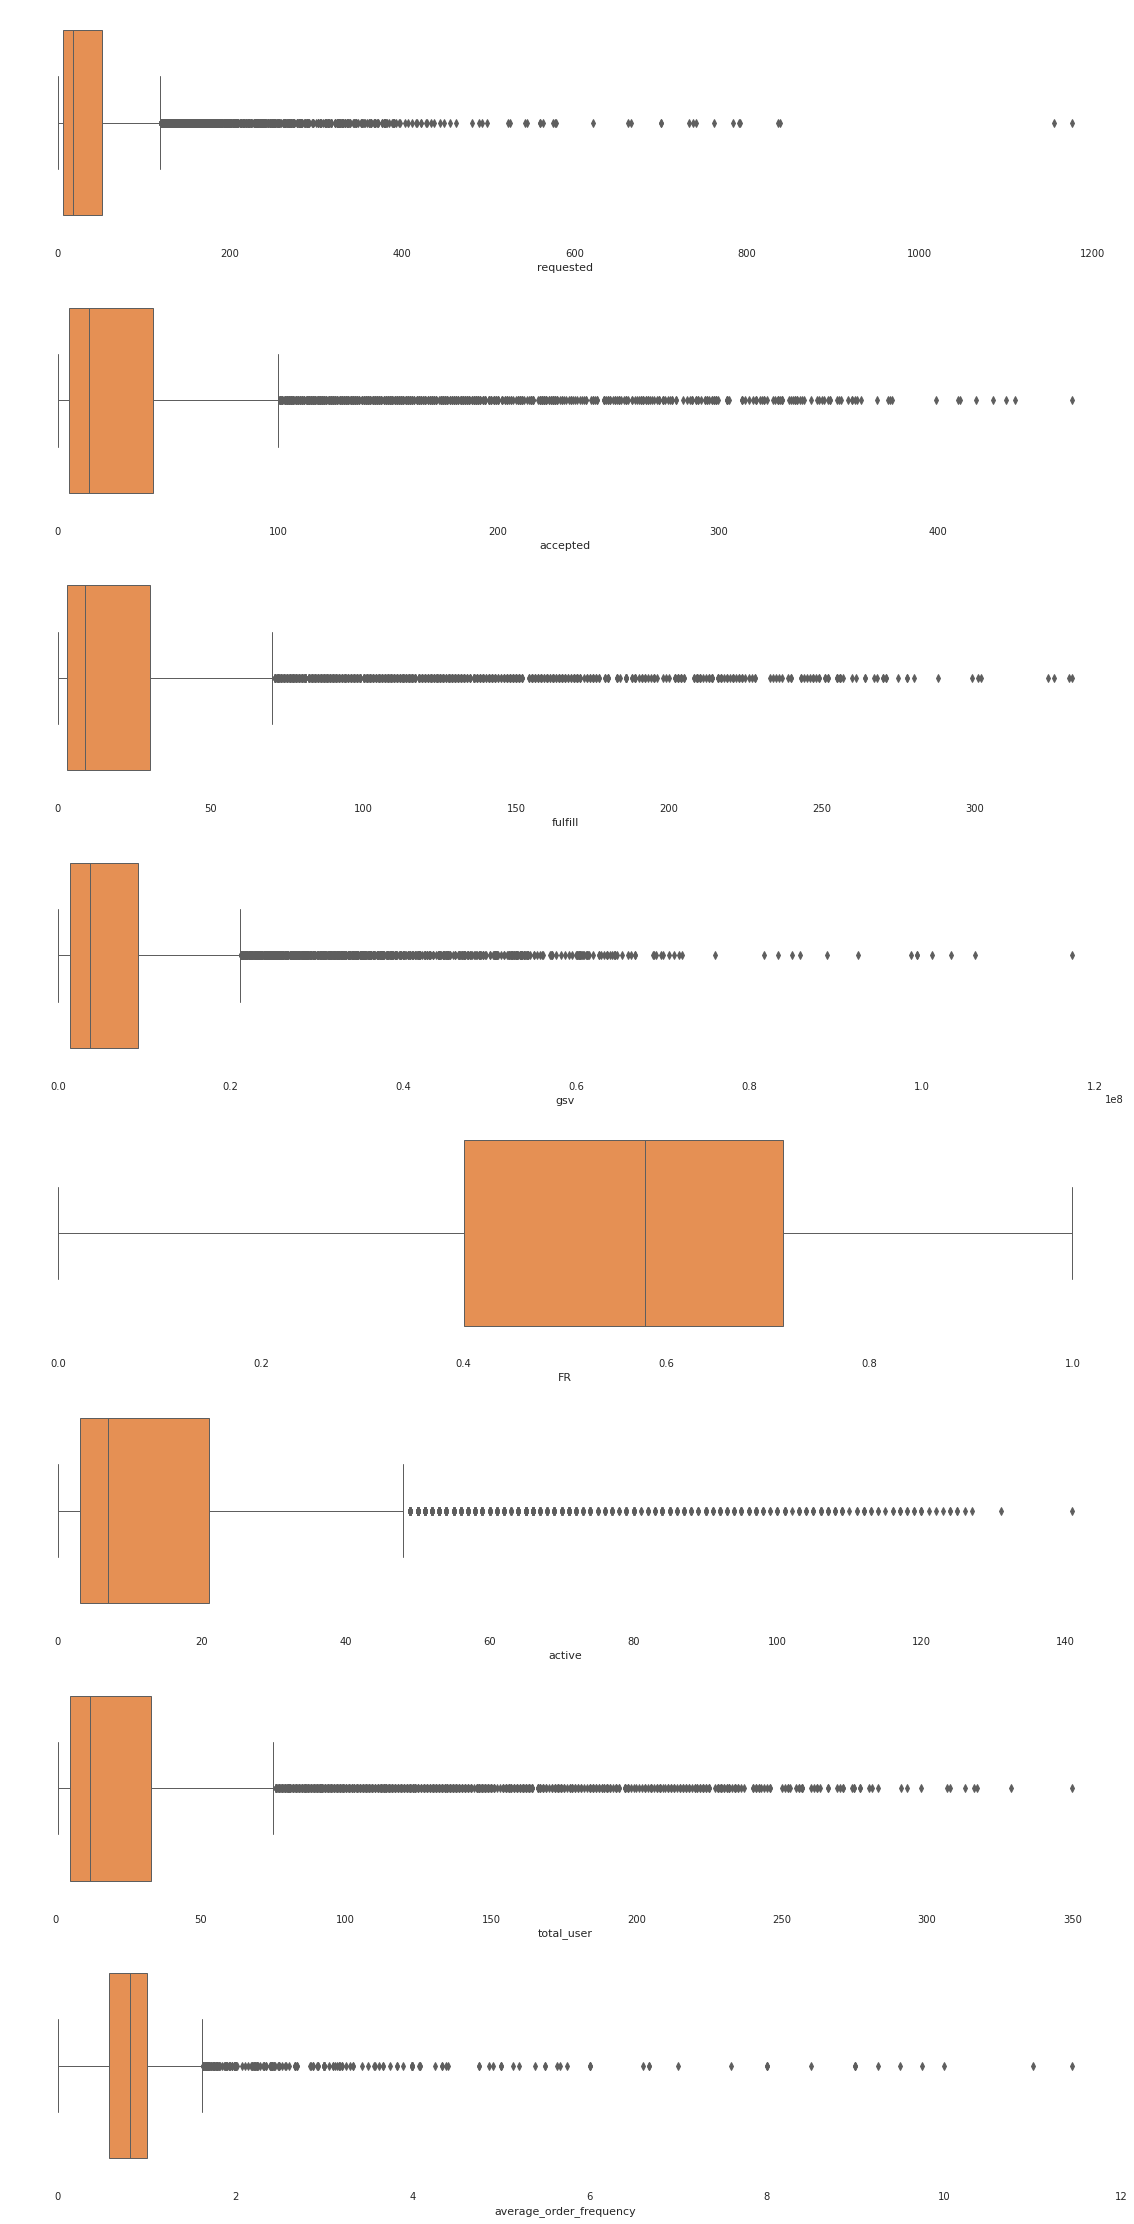

In [17]:
# kiểm tra các thuộc tính numeric có outlier không
# 'fulfill', 'gsv_excluded_vat', 'FR','active','total_user', 'average_order_frequency'
num = ['requested','accepted','fulfill', 'gsv', 'FR','active','total_user', 'average_order_frequency']

plt.figure(figsize= (20,40))
for i in range(len(num)):
  plt.subplot(len(num),1,i+1)
  sns.boxplot(df[num[i]],palette="Oranges",linewidth=1)
plt.show()
# plt.ion()

Ta thấy thuộc tính numeric đều có outliers, nên về sau khi làm scaling thì sẽ chọn robust scaling

In [18]:
# hàm tính tổng outliers của các thuộc tính
def findoutliers(df_frame,attr):
  num_outliers = 0
  num_outliers = df_frame[df_frame[attr] > (np.percentile(df_frame[attr],75) 
                                            + 1.5*scipy.stats.iqr(df_frame[attr]))].shape[0] # upper bound = q3 + (1.5*iqr)

  num_outliers += df_frame[df_frame[attr] < (np.percentile(df_frame[attr],25)
                                             - 1.5*scipy.stats.iqr(df_frame[attr]))].shape[0] # lower bound = q1 - (1.5*iqr)
  return num_outliers

In [19]:
# tìm outlier của các thuộc tính
total_outliers = 0 
for item in num:
  n = findoutliers(df,item)
  print('Tổng số outliers của thuộc tính %s là: %d' %(item,n))
  total_outliers += n
print('Tổng số outliers là',total_outliers)

Tổng số outliers của thuộc tính requested là: 884
Tổng số outliers của thuộc tính accepted là: 868
Tổng số outliers của thuộc tính fulfill là: 926
Tổng số outliers của thuộc tính gsv là: 825
Tổng số outliers của thuộc tính FR là: 0
Tổng số outliers của thuộc tính active là: 749
Tổng số outliers của thuộc tính total_user là: 905
Tổng số outliers của thuộc tính average_order_frequency là: 252
Tổng số outliers là 5409


## Phân tích đa biến

**Phân tích giữa các biến liên tục và 'requested'**

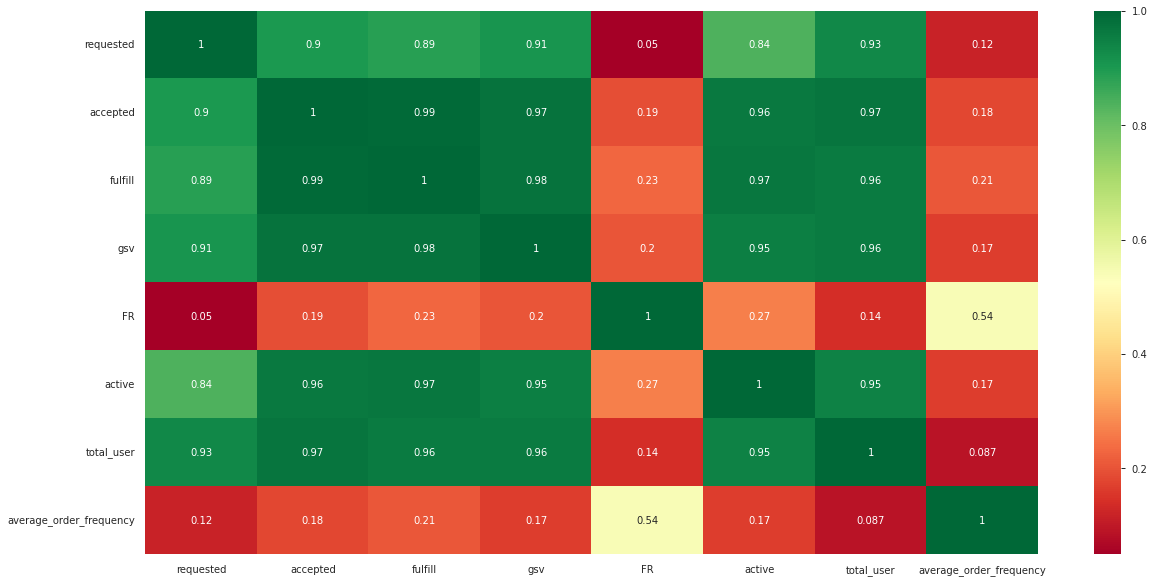

In [21]:
# Xem tương quan mối quan hệ giữa các thuộc tính với "requested"
corr_matr = df.corr()
plt.figure(figsize=(20,10))
g = sns.heatmap(corr_matr, cmap = 'RdYlGn', annot =True)
plt.show()


*   Có thể thấy các biến như accepted, fulfill, gsv, active, total_user đều tương quan ảnh hưởng mạnh đến 'requested'. 
*   Xét về bản chất thì accepted, fulfill đều mang tính chất đo lường dựa trên số đơn như 'requested'.
*   FR lại tương quan nghịch với 'requested'. Bởi vì sẽ có những khu vực, quận ít đơn nhưng FR cao, hoặc thấp, và ngược lại
*   Lựa chọn GSV, active xem xét để xây dựng mô hình dự báo về sau.





In [22]:
# xem qua các dịch vụ ở SGN
print('Tổng các dịch vụ ở SGN trong bộ dữ liệu',len(df['service_id'].unique()))
df['service_id'].unique()

Tổng các dịch vụ ở SGN trong bộ dữ liệu 6


array(['SGN-TRICYCLE', 'SGN-TRUCK-1000', 'SGN-TRUCK-2000',
       'SGN-TRUCK-500', 'SGN-VAN-1000', 'SGN-VAN-500'], dtype=object)

In [23]:
# xem qua các khu vực quận huyện ở SGN
print('Tổng các quận huuyện ở SGN trong bộ dữ liệu',len(df['district'].unique()))
df['district'].unique()

Tổng các quận huuyện ở SGN trong bộ dữ liệu 24


array(['Quận 5', 'Quận 2', 'Quận 7', 'Quận Tân Bình', 'Quận 8',
       'Quận Thủ Đức', 'Quận Bình Thạnh', 'Quận 4', 'Quận Tân Phú',
       'Huyện Bình Chánh', 'Quận 12', 'Quận 10', 'Huyện Hóc Môn',
       'Quận Gò Vấp', 'Quận 11', 'Quận Bình Tân', 'Quận 1',
       'Quận Phú Nhuận', 'Quận 6', 'Huyện Củ Chi', 'Quận 9', 'Quận 3',
       'Huyện Nhà Bè', 'Huyện Cần Giờ'], dtype=object)

In [24]:
# Tạo thêm cột Month 
df['month'] = pd.DatetimeIndex(df['period']).month

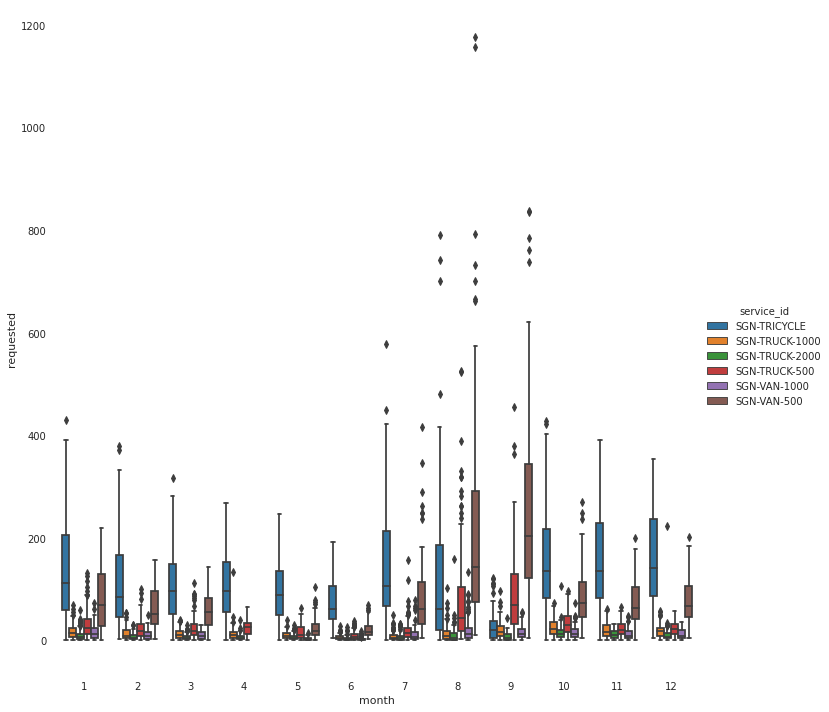

In [25]:
# Xem xét sự biến thiên nhu cầu của các loại dịch vụ theo tháng
g = sns.factorplot('month', 'requested', data = df, hue = 'service_id', 
                   kind = 'box', size =10, aspect =1.0)

**Nhận xét**: 
* Nhìn chung có sự chênh lệch nhu cầu nữa các nhóm dịch vụ với nhau,
dịch vụ xe ba gác và xe van vẫn chiếm lượng lớn. Bên cạnh đó thì tòan bộ dữ liệu được thể hiện theo tháng, chỉ có sự biến động tăng nhu cầu của 2 dịch vụ xe ba gác và xe van ở những tháng nửa cuối năm trở về sau. Ngoài ra nhìn tổng quan biểu đồ, có thể thấy những điểm ngoại lệ rất rõ, chứng tỏ rằng bộ dữ liệu chưa thực sự “sạch”, cần phải xử lý các điểm ngoại lệ.





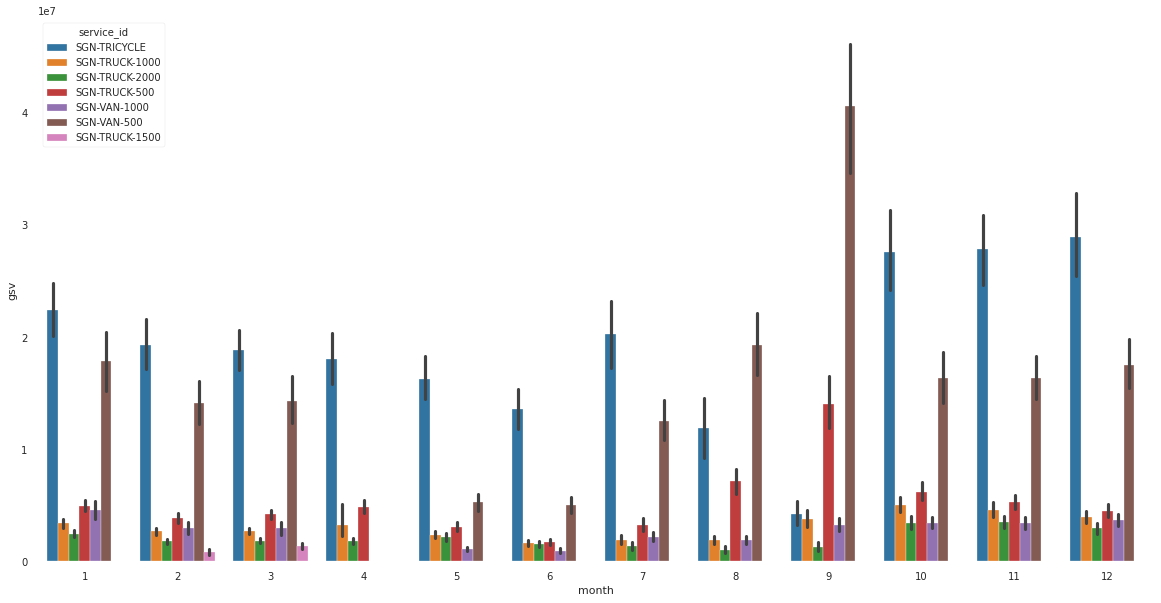

In [ ]:
# xem xét biến thiên doanh thu theo tháng
plt.figure(figsize =(20,10))
sns.barplot(data=df, x='month', y = 'gsv', hue='service_id')

Tương tự biểu đồ chỉ ra rằng doanh thu ở 2 dịch vụ xe ba gác và xe van chiếm phần lớn. Nhìn chung thì nhu cầu với doanh thu khá tỉ lệ với nhau, khi nhu cầu tăng cao đồng nghĩa sẽ có doanh thu, nhưng ta chỉ thấy rõ đối với dịch vụ có nhu cầu cao rõ rệt như dịch vụ xe ba gác với xe van. Còn lại vẫn có trường hợp khi nhu cầu tăng cao nhưng khả năng đáp ứng là chưa có thì vẫn không thể tăng được doanh thu. Tổng quan về hai biểu đồ có thể kết luận là nhu cầu sẽ tăng vào giai đoạn cuối năm.




Text(0.5, 1.0, 'Số đơn ở các dịch vụ theo thời gian')

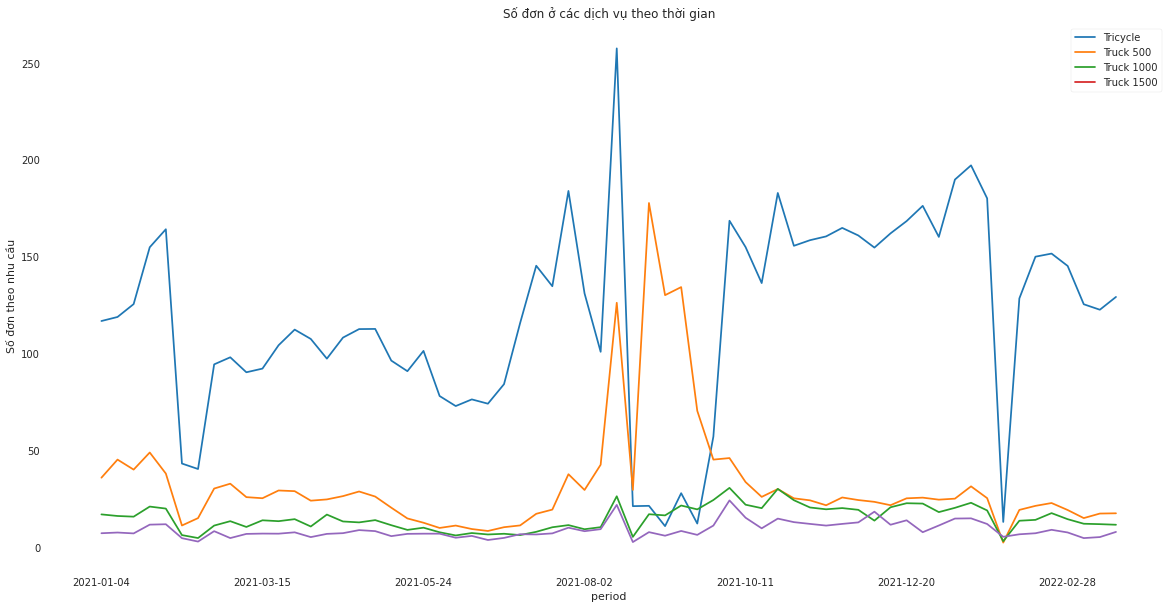

In [27]:
# xem xét biến động nhu cầu qua toàn bộ dữ liệu
groupDate_tri=df[df["service_id"]=="SGN-TRICYCLE"].groupby('period').mean()
groupDate_van500=df[df["service_id"]=="SGN-VAN-500"].groupby('period').mean()
groupDate_van1000=df[df["service_id"]=="SGN-VAN-1000"].groupby('period').mean()
groupDate_truck500=df[df["service_id"]=="SGN-TRUCK-500"].groupby('period').mean()
groupDate_truck1000=df[df["service_id"]=="SGN-TRUCK-1000"].groupby('period').mean()
groupDate_truck1500=df[df["service_id"]=="SGN-TRUCK-1500"].groupby('period').mean()
groupDate_truck2000=df[df["service_id"]=="SGN-TRUCK-2000"].groupby('period').mean()

plt.figure(figsize=(20,10))
groupDate_tri['requested'].plot()
# groupDate_van500['requested'].plot()
# groupDate_van1000['requested'].plot()
groupDate_truck500['requested'].plot()
groupDate_truck1000['requested'].plot()
groupDate_truck1500['requested'].plot()
groupDate_truck2000['requested'].plot()


plt.ylabel('Số đơn theo nhu cầu')
plt.legend(['Tricycle','Truck 500','Truck 1000','Truck 1500'])
plt.title('Số đơn ở các dịch vụ theo thời gian')

Text(0.5, 1.0, 'Số đơn ở các dịch vụ theo thời gian')

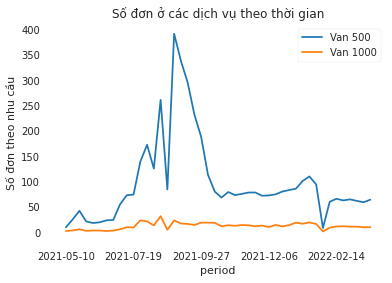

In [28]:
groupDate_van500['requested'].plot()
groupDate_van1000['requested'].plot()
plt.ylabel('Số đơn theo nhu cầu')
plt.legend(['Van 500','Van 1000'])
plt.title('Số đơn ở các dịch vụ theo thời gian')

**Nhận xét**:
Xem xét biến động nhu cầu của các dịch vụ qua toàn bộ dữ liệu theo thời gian. Nhìn tổng quan bộ dữ liệu thì ta thấy dữ liệu không có tính mùa (seasonal) và theo chu kỳ (cycila), khá ổn định (stationary) ở các nhóm dịch vụ nhu cầu thấp, nhưng vẫn có vài điểm biến động bất thường (random fluctuation).
 Phân tích cụ thể ta thấy rõ sự phân hóa về nhu cầu sử dụng giữa các dịch vụ với nhau, với nhóm dịch vụ xe tải có tải trọng 500kg, 1000kg, 2000kg và xe van tải trọng 1000kg thì có lượng nhu cầu khá thấp nhưng rất ổn định và đều trên toàn bộ chuỗi thời gian phân tích. Có vài sự biến động nhẹ ở giai đoạn tháng 8, tháng 9 tăng nhẹ và tháng 1 giảm nhẹ. Điều này có thể giải thích là nhu cầu tăng vào thời điểm giãn cách toàn xã hội dịch COVID-19, còn với thời điểm Tết Nguyên Đán thì nhu cầu giảm.
Đối với dịch vụ xe ba gác, xe van 500kg và xe tải 500kg có lượng nhu cầu lớn trong đó lớn nhất vẫn là xe ba gác. Ta nhận thấy rằng cả 3 dịch vụ này có sự tương đồng về biến động nhu cầu, trong giai đoạn từ tháng 3 đến tháng 4 và cuối tháng 10 đến tháng 12, tuy có vài tuần sẽ có những biến động ngẫu nhiên nhưng nhìn chung vẫn ổn định nhất so với các tháng còn lại. Trong khoảng thời gian giãn cách xã hội COVID-19 (tháng 8, tháng 9) thì nhu cầu tăng rất mạnh, tạo thành xu hướng tăng đến khi đạt đỉnh với khoảng 250 đơn trong 1 tuần ở dịch vụ xe ba gác. Tuy nhiên cũng bởi vì ảnh hưởng dịch bệnh nên có thời điểm cấm vận chuyển và thời điểm được phép vận chuyển nên nhu cầu cũng ảnh hưởng rất nhiều, dẫn đến khi nhìn vào biểu đồ của tòan dữ liệu ta thấy rất rõ những biến động ngẫu nhiên.


Text(0.5, 1.0, 'GSV for Truck 2000 service')

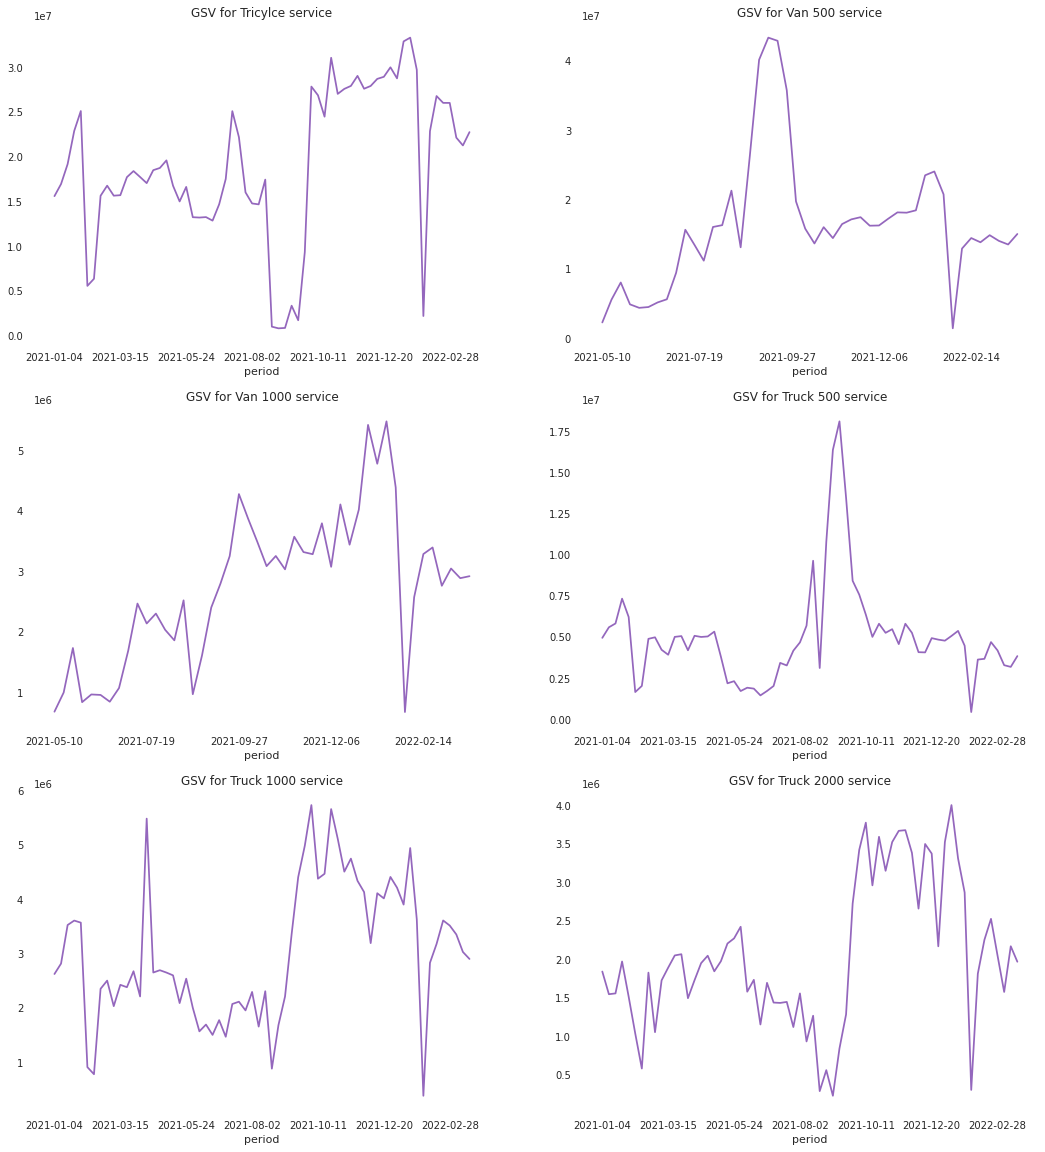

In [30]:
# Xem xét biến động doanh thu của các loại dịch vụ thời gian của dữ liệu

plt.figure(figsize=(18,20))
plt.subplot(3,2,1)
groupDate_tri['gsv'].plot(color ='tab:purple')
plt.title('GSV for Tricylce service')

plt.subplot(3,2,2)
groupDate_van500['gsv'].plot(color ='tab:purple')
plt.title('GSV for Van 500 service')

plt.subplot(3,2,3)
groupDate_van1000['gsv'].plot(color ='tab:purple')
plt.title('GSV for Van 1000 service')

plt.subplot(3,2,4)
groupDate_truck500['gsv'].plot(color ='tab:purple')
plt.title('GSV for Truck 500 service')

plt.subplot(3,2,5)
groupDate_truck1000['gsv'].plot(color ='tab:purple')
plt.title('GSV for Truck 1000 service')


plt.subplot(3,2,6)
groupDate_truck2000['gsv'].plot(color ='tab:purple')
plt.title('GSV for Truck 2000 service')

**Nhận xét** : Quan sát tổng thể có thể thấy rằng có sự tương đồng nghĩa nhu cầu và doanh thu nhưng vẫn có vài thời điểm có sự chênh lệch giữa doanh thu cao nhưng nhu cầu lại khá thấp và ngược lại. Cụ thể là ở dịch vụ xe ba gác vào khoảng thời gian từ tháng 10 đến tháng 12, nhu cầu tương đối ổn định chỉ ngang hoặc thấp hơn so với giai đoạn cách ly dịch bệnh nhưng doanh thu lại cao đạt đỉnh . Bên cạnh đó , với xe Van 1000kg hay xe tải 1000kg thì tuy có nhu cầu thấp nhưng giá trị của mỗi chuyến lại rất cao từ đó mang lại nguồn doanh thu có thể so sánh với những dịch vụ khác. 

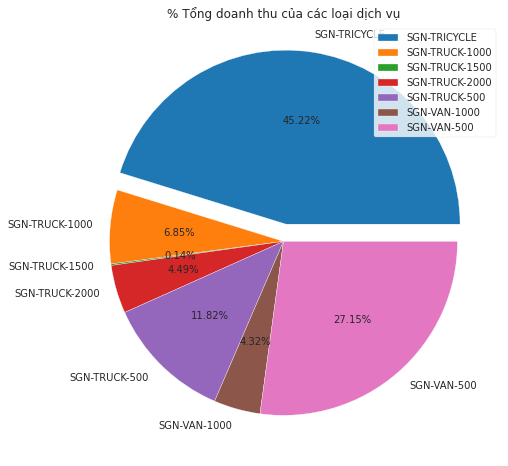

In [ ]:
# Vẽ pie chart cho Tổng nhu cầu của các loại dịch vụ
plt.figure(figsize=(8,8))
explode = (0.1, 0, 0, 0,0,0,0)
gsv = df.groupby("service_id").agg({"gsv":"sum"})
plt.pie(gsv["gsv"], labels = gsv.index, autopct='%1.2f%%',explode=explode)
plt.title("% Tổng doanh thu của các loại dịch vụ")
plt.legend()
plt.show() 

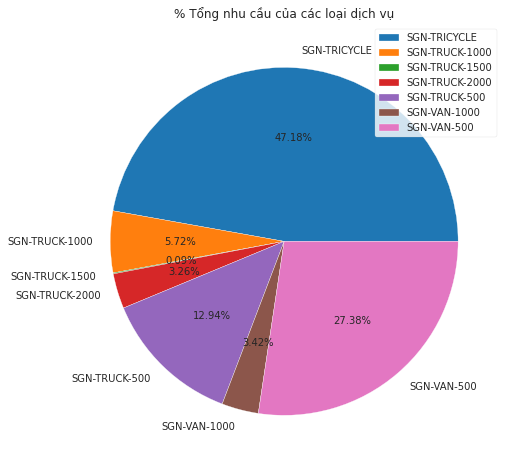

In [ ]:
# Vẽ pie chart cho tổng doanh thu
plt.figure(figsize=(8,8))
volume = df.groupby("service_id").agg({"requested":"sum"})
plt.pie(volume["requested"], labels = volume.index, autopct='%1.2f%%')
plt.title("% Tổng nhu cầu của các loại dịch vụ")
plt.legend()
plt.show() 

Xét về demand và doanh thu thì Tricycle vẫn là dịch vụ được chọn sử dụng nhiều và mang lại doanh thu nhiều nhất.


# Phân tích mỗi quan hệ giữa các biến phân loại


In [ ]:
df.head()

period city cate    service_id       district  requested  accepted  \
0  2021-01-04  SGN  SME  SGN-TRICYCLE         Quận 5         86        84   
1  2021-01-04  SGN  SME  SGN-TRICYCLE         Quận 2         98        62   
2  2021-01-04  SGN  SME  SGN-TRICYCLE         Quận 7        135       106   
3  2021-01-04  SGN  SME  SGN-TRICYCLE  Quận Tân Bình        305       290   
4  2021-01-04  SGN  SME  SGN-TRICYCLE         Quận 8         71        51   

   fulfill  gsv_excluded_vat   FR  active  total_user  \
0       56          13688235 0.65      34          59   
1       37          10822549 0.38      28          62   
2       72          22173529 0.53      38          95   
3      171          44098039 0.56      87         187   
4       26           7346078 0.37      24          42   

   average_order_frequency  month       cps  
0                     0.95      1 244432.77  
1                     0.60      1 292501.32  
2                     0.76      1 307965.68  
3                     0.91      1 257883.27  
4                     0.62      1 282541.46

Trong bộ dữ liệu ngoài những biến liên tục là những biến mang giá trị đếm ra thì vẫn còn các biến phân loại mục đích bổ sung những biến này vào để củng cố thêm sự chính xác cho mô hình dự báo. Với các biến phân loại đang có gồm: Period, service_id,, district, month.
Sử dụng kiểm định Chi-Square – một phương pháp thông kê được sử dụng để xác định xem hai biến phân loại có mối tương quan đáng kể giữa chúng hay không hay là hai biến sẽ độc lập nhau.


In [32]:
# Dùng Kiểm định Chi-Square để kiểm định sự phụ thuộc của các thuộc tính phân loại

cat_list = ['period', 'service_id', 'district', 'month']
prob = 0.95
alpha = 1 - prob

for i in range(0, len(cat_list)-1):
    for j in range(i+1, len(cat_list)):
        
        two_way_table = pd.crosstab(df[cat_list[i]], df[cat_list[j]])        
        stat, p, dof, expected = chi2_contingency(two_way_table)        
        critical = chi2.ppf(prob, dof)
        
        if p <= alpha:
            print('Phân tích %s và %s:' %(cat_list[i], cat_list[j]))
            print('probability=%.3f, critical=%.3f, stat=%.3f, alpha=%.3f, p-value=%.3f' %(prob, critical, stat, alpha,p))
            print('%.3f <= %.3f -> Hai biến %s và %s phụ thuộc (Reject H0)' %(p, alpha, cat_list[i], cat_list[j]))  

Phân tích period và service_id:
probability=0.950, critical=357.391, stat=747.264, alpha=0.050, p-value=0.000
0.000 <= 0.050 -> Hai biến period và service_id phụ thuộc (Reject H0)
Phân tích period và month:
probability=0.950, critical=755.352, stat=83512.000, alpha=0.050, p-value=0.000
0.000 <= 0.050 -> Hai biến period và month phụ thuộc (Reject H0)
Phân tích service_id và month:
probability=0.950, critical=73.311, stat=311.230, alpha=0.050, p-value=0.000
0.000 <= 0.050 -> Hai biến service_id và month phụ thuộc (Reject H0)


* ta thấy biến 'period' và 'month' phụ thuộc nhau, cho nên sẽ bỏ bớt trong quá trình xây dựng model về sau
* Hai biến 'service_id' và 'district' độc lập nhau



# Phân tích mối quan giữa các biến phân loại và 'Requested'




Như phần tích ở trên, ta thấy lượng đơn theo nhu cầu có biến động theo thời gian. Vì vậy ta có thể phân tích liệu nhu cầu có thay đổi theo các mùa trong năm không.


# Tạo thêm cột 'season'
*  spring months are (1,2,3)
*  summer months are (4,5,6)
*  autumn months are (7,8,9)
*  winter months are (10,11,12)


In [33]:
def convert_month(month):
    if month == 1 or month == 2 or month == 3:
        return 0
    elif month == 4 or month == 5 or month == 6:
        return 1
    elif month == 7 or month == 8 or month == 9:
        return 2
    else:
        return 3

In [34]:
#Tạo thêm côt 'season'
df['season'] = df['month'].apply(lambda x: convert_month(x))

In [ ]:
df.head()

period city cate    service_id       district  requested  accepted  \
0  2021-01-04  SGN  SME  SGN-TRICYCLE         Quận 5         86        84   
1  2021-01-04  SGN  SME  SGN-TRICYCLE         Quận 2         98        62   
2  2021-01-04  SGN  SME  SGN-TRICYCLE         Quận 7        135       106   
3  2021-01-04  SGN  SME  SGN-TRICYCLE  Quận Tân Bình        305       290   
4  2021-01-04  SGN  SME  SGN-TRICYCLE         Quận 8         71        51   

   fulfill  gsv_excluded_vat   FR  active  total_user  \
0       56          13688235 0.65      34          59   
1       37          10822549 0.38      28          62   
2       72          22173529 0.53      38          95   
3      171          44098039 0.56      87         187   
4       26           7346078 0.37      24          42   

   average_order_frequency  month       cps  season  
0                     0.95      1 244432.77       0  
1                     0.60      1 292501.32       0  
2                     0.76      1 307965.68       0  
3                     0.91      1 257883.27       0  
4                     0.62      1 282541.46       0

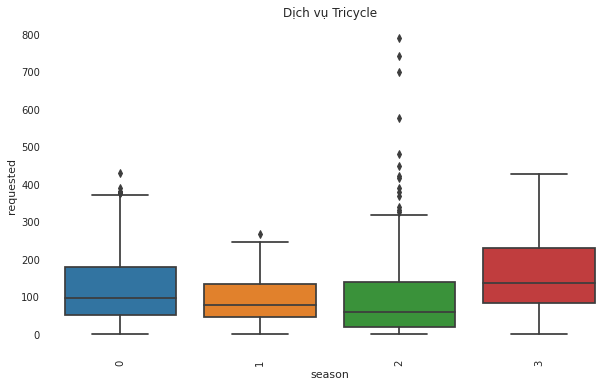

In [35]:
#Thuộc tính 'season' có ảnh hưởng đến nhu cầu sử dụng dịch vụ tricycle không
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=df[df['service_id']=='SGN-TRICYCLE'],
           x='season', y='requested', ax=ax)
plt.xticks(rotation=90)
plt.title("Dịch vụ Tricycle")
plt.show()
#plt.ion()

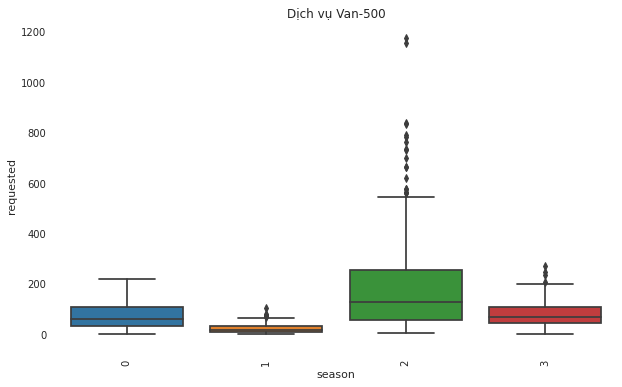

In [36]:
#Thuộc tính 'season' có ảnh hưởng đến nhu cầu sử dụng dịch vụ van 500 không
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=df[df['service_id']=='SGN-VAN-500'],
           x='season', y='requested', ax=ax)
plt.xticks(rotation=90)
plt.title("Dịch vụ Van-500")
plt.show()

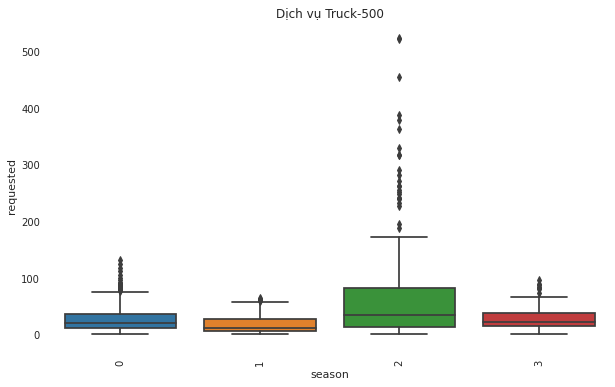

In [37]:
#Thuộc tính 'season' có ảnh hưởng đến nhu cầu sử dụng dịch vụ truck 500 không
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=df[df['service_id']=='SGN-TRUCK-500'],
           x='season', y='requested', ax=ax)
plt.xticks(rotation=90)
plt.title("Dịch vụ Truck-500")
plt.show()

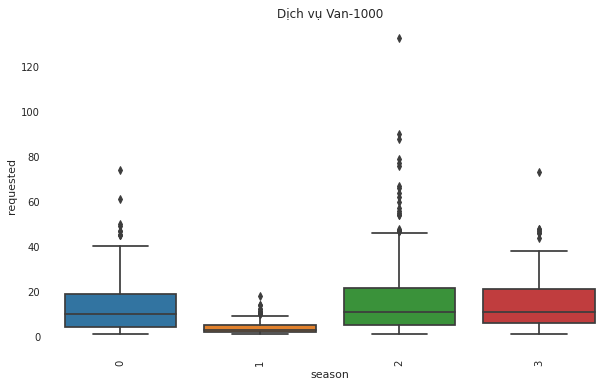

In [38]:
#Thuộc tính 'season' có ảnh hưởng đến nhu cầu sử dụng dịch vụ van 1000 không
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=df[df['service_id']=='SGN-VAN-1000'],
           x='season', y='requested', ax=ax)
plt.xticks(rotation=90)
plt.title("Dịch vụ Van-1000")
plt.show()

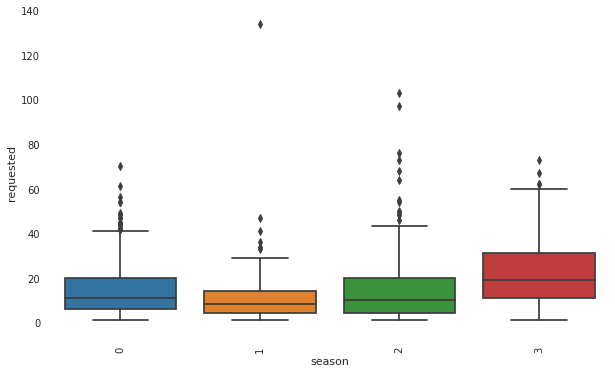

In [39]:
#Thuộc tính 'season' có ảnh hưởng đến nhu cầu sử dụng dịch vụ truck 1000 không
#type == 'conventional'
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=df[df['service_id']=='SGN-TRUCK-1000'],
           x='season', y='requested', ax=ax)
plt.xticks(rotation=90)
plt.show()

* Nhận xét: yếu tố mùa có ảnh hưởng đến các dịch vụ có nhu cầu cao như tricycle, van 500, và truck 500. Còn những dịch vụ còn lại ảnh hưởng ko đáng kể. Nhưng về tổng quan 3 dvu kể trên chiếm lượng demand khá lớn vì thế trong xây dựng model sẽ đưa them biến theo mùa vào.

In [40]:
df2 = df[df.service_id.isin(['SGN-TRICYCLE','SGN-VAN-500'])]
df3 = df[df.service_id.isin(['SGN-TRUCK-500','SGN-TRUCK-1000'])]

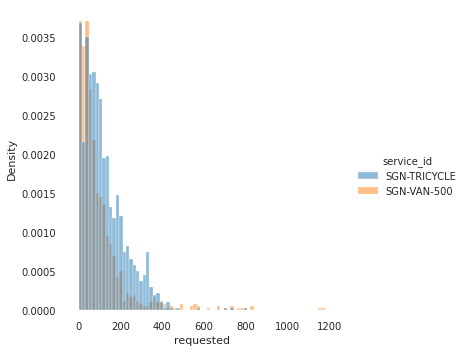

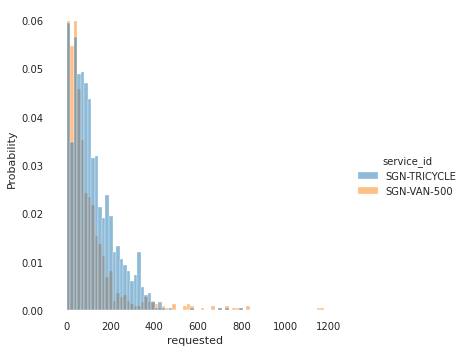

In [42]:
#Thuộc tính 'service_id' có ảnh hưởng lên 'requested' hay không

sns.displot(df2, x='requested', hue='service_id', stat='density')
sns.displot(df2, x='requested', hue='service_id', stat='probability')


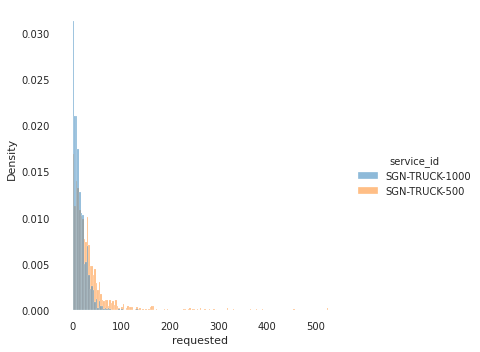

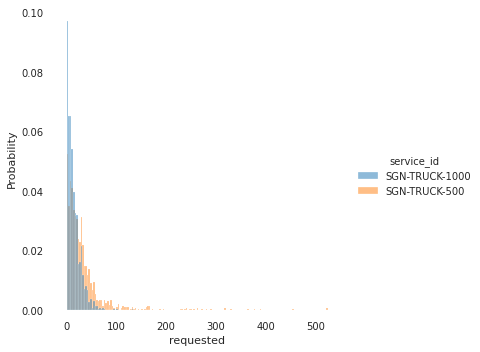

In [43]:
sns.displot(df3, x='requested', hue='service_id', stat='density')
sns.displot(df3, x='requested', hue='service_id', stat='probability')

**Nhận xét**:
Dựa vào 2 biểu đồ trên, kết quả cho thấy biến ‘service_id’ với ‘requested’ không ảnh hưởng với nhau. Dữ liệu lệch về 1 phía, cụ thể là lệch tích cực, điều này có ý nghĩa là lượng nhu cầu cao có điểm dữ liệu nhiều hơn lượng nhu cầu thấp. Vì vậy khi đào tạo mô hình dự báo trên dữ liệu này sẽ hoạt động dự báo tốt hơn với những điểm có lượng nhu cầu cao hơn là những điểm có lượng nhu cầu thấp. 
Ngoài ra với độ lệch như biểu đồ, cũng cho biết thêm về hướng của ngoại lai, hầu hết các ngoại lai đều có mặt ở bên phải phân phối. Điều này giúp ích cho việc xây dựng công thức loại bỏ ngoại lai về sau.


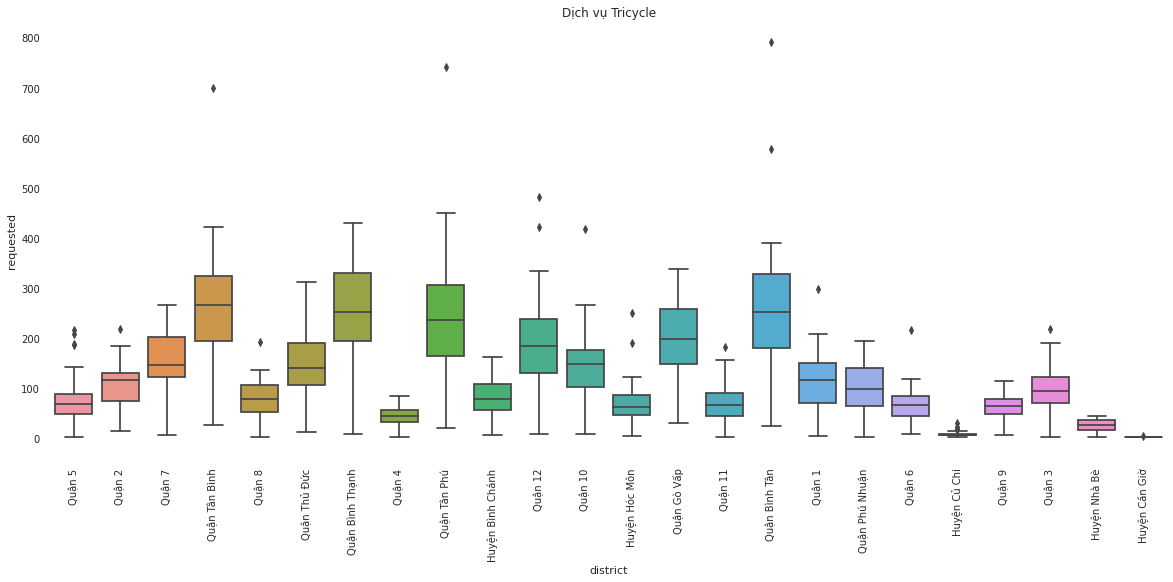

In [ ]:
#Thuộc tính 'district' có ảnh hưởng đến 'requested' dịch vụ không
#type = tricycle
fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=df[df['service_id']=='SGN-TRICYCLE'],
           x='district', y='requested', ax=ax)
plt.xticks(rotation=90)
plt.title('Dịch vụ Tricycle')
plt.show()

khu vực quận Tân Bình, Bình Thạnh, Bình Tân, Tân Phú có lượng đơn cao nhất đối với dịch vụ xe ba gác

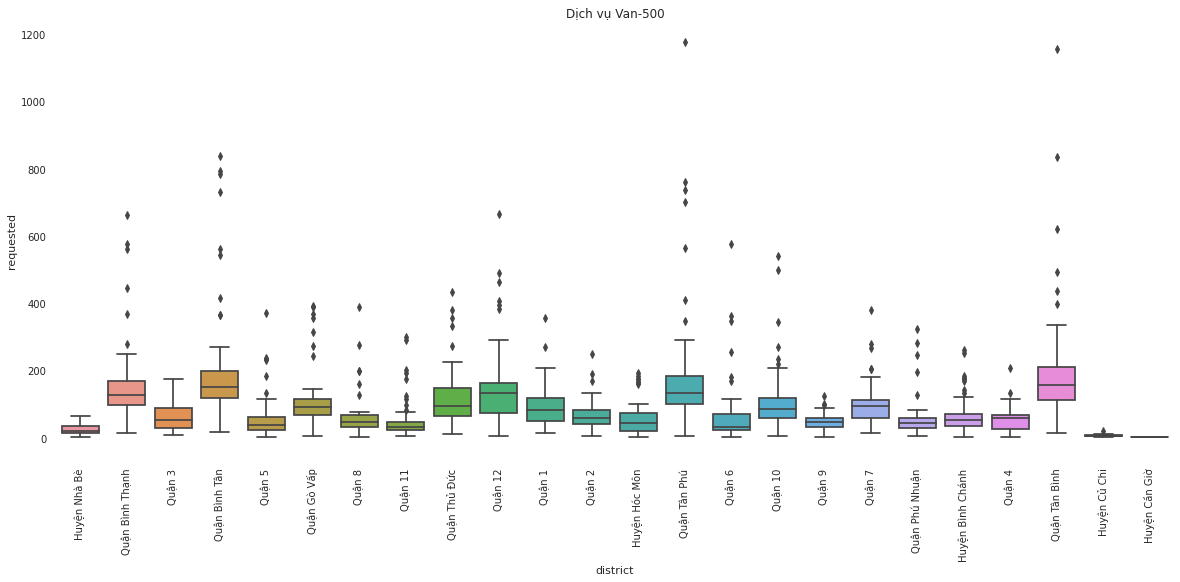

In [ ]:
# xe van 500
fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=df[df['service_id']=='SGN-VAN-500'],
           x='district', y='requested', ax=ax)
plt.xticks(rotation=90)
plt.title('Dịch vụ Van-500')
plt.show()

* Nhận xét: demand cao ở các quận Bình Thạnh, Bình Tân, Thủ Đức, Tân phú, Tân Bình.

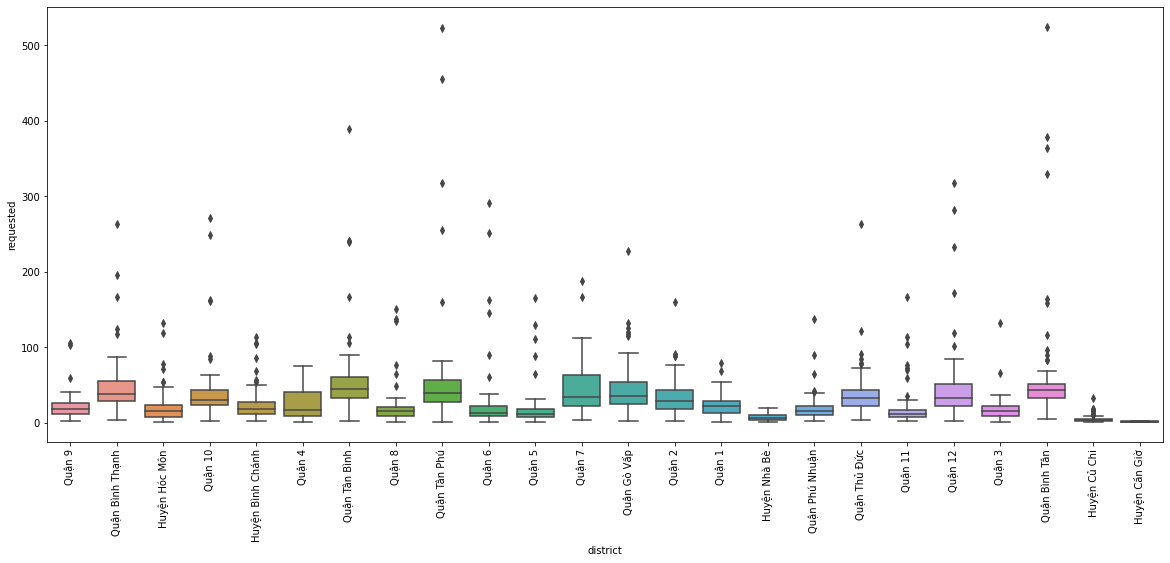

In [ ]:
# xe truck 500
fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=df[df['service_id']=='SGN-TRUCK-500'],
           x='district', y='requested', ax=ax)
plt.xticks(rotation=90)
plt.show()

* Nhận xét: cao ở các khu vực quân 4, quận 7, Tân Bình, Tân Phú.

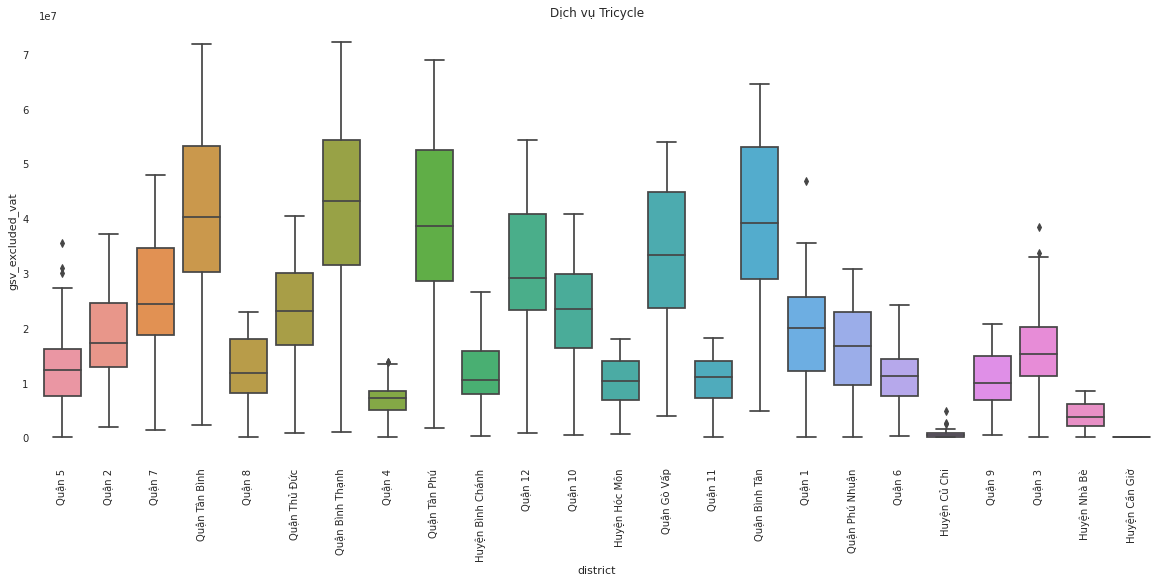

In [ ]:
#Thuộc tính 'district' có ảnh hưởng đến 'gsv'  không
#type = 'Tricyle'
fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=df[df['service_id']=='SGN-TRICYCLE'],
           x='district', y='gsv_excluded_vat', ax=ax)
plt.xticks(rotation=90)
plt.title('Dịch vụ Tricycle')
plt.show()

* Nhận xét: Tân bình, Bình Thạnh, Tân Phú, Bình Tân là những khu vực có gsv cao, tương đương với việc demand cao dẫn đến gsv cao

*   Thấp nhất là Quận 4, Củ Chi, Cần Giờ, Nhà Bè.





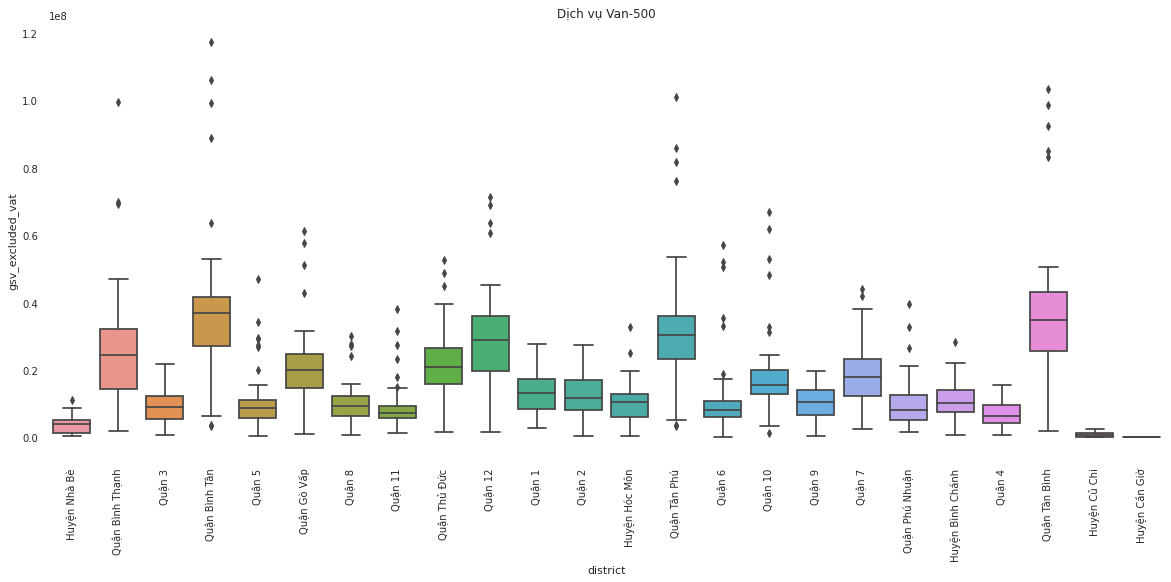

In [ ]:
#Thuộc tính 'district' có ảnh hưởng đến 'gsv'  không
#type = 'Van 500'
fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=df[df['service_id']=='SGN-VAN-500'],
           x='district', y='gsv_excluded_vat', ax=ax)
plt.xticks(rotation=90)
plt.title('Dịch vụ Van-500')
plt.show()

Khá tương đồng với Demand

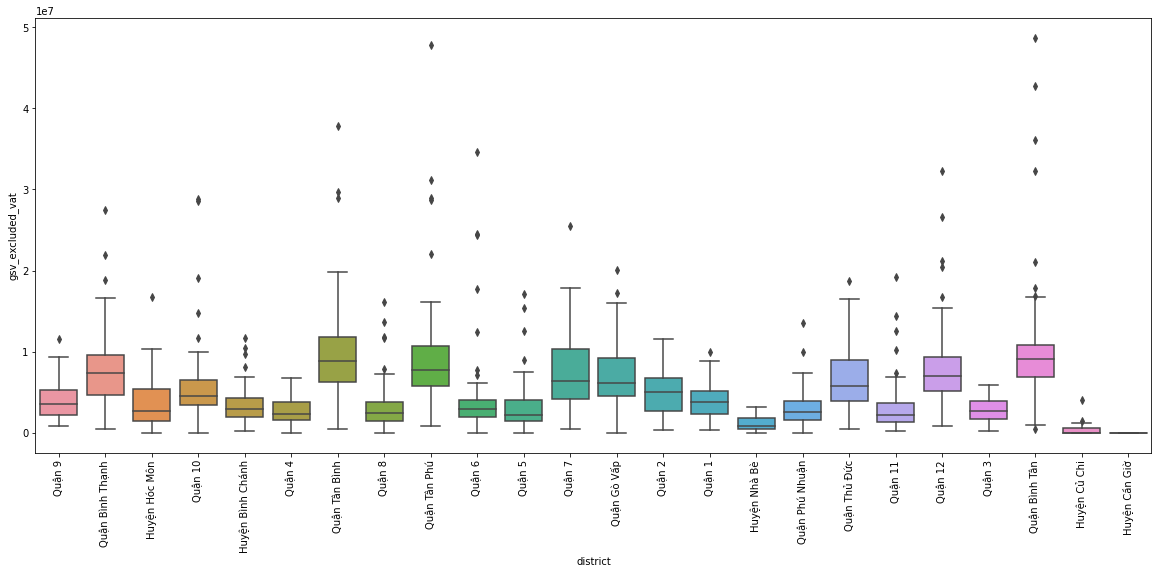

In [ ]:
#Thuộc tính 'district' có ảnh hưởng đến 'gsv'  không
#type = 'Truck 500'
fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=df[df['service_id']=='SGN-TRUCK-500'],
           x='district', y='gsv_excluded_vat', ax=ax)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Ta phân tích kỹ hơn bằng cách chọn ra top 10 khu vực có doanh thu và nhu cầu cao nhất
#để xem xét sự thay đổi qua các tháng
region_df = df.groupby("district").agg({"gsv_excluded_vat":'sum'})
region_df = region_df.sort_values('gsv_excluded_vat', ascending=False).reset_index()
top_10_region = region_df.head(10)['district'].tolist()
region_df_10 = df[df['district'].isin(top_10_region)]

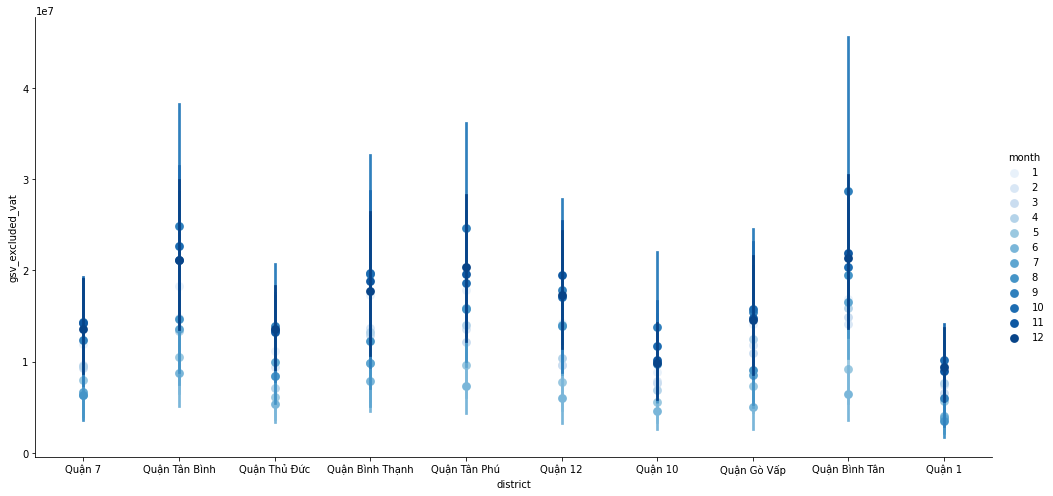

In [ ]:
g = sns.factorplot('district','gsv_excluded_vat',data=region_df_10,
                   hue='month',
                   size=7,
                   aspect=2,
                   palette='Blues',
                   join=False,
              )

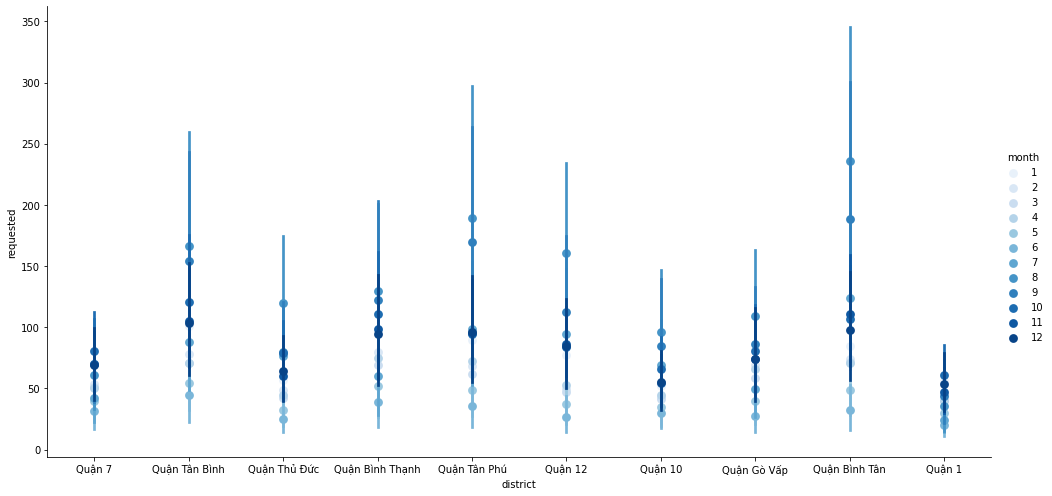

In [ ]:
g = sns.factorplot('district','requested',data=region_df_10,
                   hue='month',
                   size=7,
                   aspect=2,
                   palette='Blues',
                   join=False,
              )

**Nhận xét**:
Phân tích kỹ hơn bằng cách chọn ra 10 khu vực có doanh thu và số lượng nhu cầu cao nhất để xem xét sự thay đổi của nhu cầu và doanh thu qua các tháng.
* Từ 2 biểu đồ factorplot, ta thấy 4 khu vực có nhu cầu và doanh thu cao là: Tân Bình, Bình Thạnh, Tân Phú, Quận 12.
* Trong 4 khu vực này, điều thú vị là không phải có nhu cầu cao thì doanh thu sẽ cao như ta phân tích trường hợp cụ thể phía trên. Điển hình là quận Tân phú có nhu cầu cao thứ 2 nhưng về mặt doanh thu chỉ đứng thứ 4. Trong khi đó quận Tân Bình thì ngược lại.
* Vì vậy, khi xem xét khu vực tiềm năng, ta cần xét 2 yếu tố song song là nhu cầu và doanh thu. Vì để có được doanh thu, ta cần phải kiểm soát tốt được lượng nhu cầu nghĩa là phải hoàn thành đơn hàng từ khách hàng, nếu khu vực đó có nhu cầu cao nhưng không có tài xế chạy đơn hay nhiều lý do khác để không đáp ứng được thì cũng mặc dù có nhu cầu nhưng cũng không có doanh thu.
* Trong những khu vực trên thì có quận Tân Bình là tiềm năng. Nhưng về mặt vận hành sẽ có thêm những khu vực lân cận như quận 10, Phú Nhuận, 11, và Tân Phú.
*	Ngoài ra không chỉ các quận trung tâm có nhu cầu cao và doanh thu cao thì cần phải kiểm soát và mở rộng phát triển. Với những khu vực ngoài thành nếu ta có thể xử lý tốt vẫn có thể đáp ứng tốt nhu cầu của khách hàng và đem lại nguồn doanh thu ổn định.

In [ ]:
# Ta phân tích kỹ hơn bằng cách chọn ra top 10 khu vực có doanh thu và nhu cầu thấp nhất
#để xem xét sự thay đổi qua các tháng
region_df = df.groupby("district").agg({"gsv":'sum'})
region_df = region_df.sort_values('gsv_excluded_vat', ascending=True).reset_index()
top_10_region = region_df.head(10)['district'].tolist()
region_df_10 = df[df['district'].isin(top_10_region)]

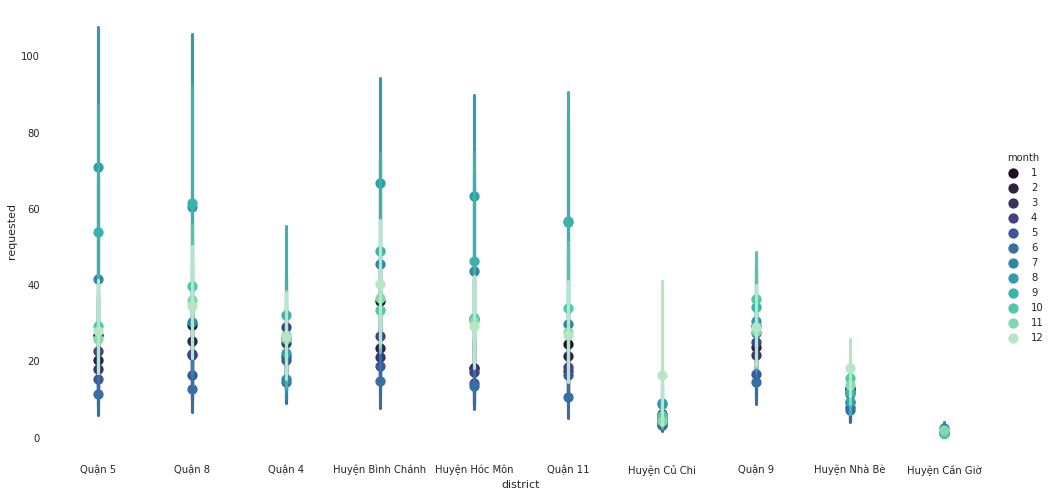

In [ ]:
g = sns.factorplot('district','requested',data=region_df_10,
                   hue='month',
                   size=7,
                   aspect=2,
                   palette='mako',
                   join=False,
              )

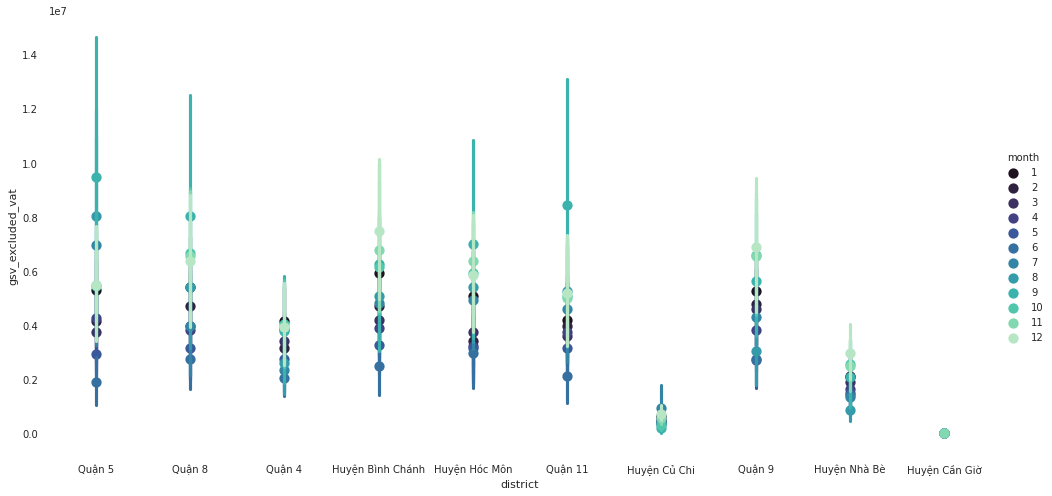

In [ ]:
g = sns.factorplot('district','gsv_excluded_vat',data=region_df_10,
                   hue='month',
                   size=7,
                   aspect=2,
                   palette='mako',
                   join=False,
              )

## **Xây dựng mô hình**

Dự báo nhu cầu -> Biến chính 'requested'
Dự trên phân tích thì các biến có ảnh hưởng và có quan hệ với 'requested' là fulfill, active, gsv, district, service_id, month, season.

In [ ]:
df.tail()

period city cate   service_id         district  requested  accepted  \
7657  2022-03-21  SGN  SME  SGN-VAN-500    Huyện Hóc Môn         42        37   
7658  2022-03-21  SGN  SME  SGN-VAN-500          Quận 12         73        66   
7659  2022-03-21  SGN  SME  SGN-VAN-500  Quận Bình Thạnh        136       133   
7660  2022-03-21  SGN  SME  SGN-VAN-500           Quận 8         44        41   
7661  2022-03-21  SGN  SME  SGN-VAN-500   Quận Phú Nhuận         42        42   

      fulfill       gsv   FR  active  total_user  average_order_frequency  \
7657       29  11203148 0.69      22          28                     1.04   
7658       54  19822593 0.74      47          60                     0.90   
7659       94  24125185 0.69      53          76                     1.24   
7660       33   9189444 0.75      21          26                     1.27   
7661       32   9912593 0.76      22          37                     0.86   

      month       cps  season  
7657      3 386315.45       0  
7658      3 367085.06       0  
7659      3 256650.90       0  
7660      3 278468.00       0  
7661      3 309768.53       0

In [46]:
df_tricycle = df[df.service_id.isin(['SGN-TRICYCLE','SGN-VAN-500'])]
df_tricycle = df_tricycle.reset_index()
del df_tricycle['index']

In [47]:
df_final = df_tricycle[['gsv', 'district', 'requested','period','season','fulfill','active','service_id']]
df_final.tail()

gsv         district  requested      period  season  fulfill  \
2469  11203148    Huyện Hóc Môn         42  2022-03-21       0       29   
2470  19822593          Quận 12         73  2022-03-21       0       54   
2471  24125185  Quận Bình Thạnh        136  2022-03-21       0       94   
2472   9189444           Quận 8         44  2022-03-21       0       33   
2473   9912593   Quận Phú Nhuận         42  2022-03-21       0       32   

      active   service_id  
2469      22  SGN-VAN-500  
2470      47  SGN-VAN-500  
2471      53  SGN-VAN-500  
2472      21  SGN-VAN-500  
2473      22  SGN-VAN-500

In [48]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2474 entries, 0 to 2473
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   gsv         2474 non-null   int64 
 1   district    2474 non-null   object
 2   requested   2474 non-null   int64 
 3   period      2474 non-null   object
 4   season      2474 non-null   int64 
 5   fulfill     2474 non-null   int64 
 6   active      2474 non-null   int64 
 7   service_id  2474 non-null   object
dtypes: int64(5), object(3)
memory usage: 154.8+ KB


In [ ]:
df_final.describe()

gsv  requested  season  fulfill  active
count      2474.00    2474.00 2474.00  2474.00 2474.00
mean   18287001.32     111.51    1.36    65.96   37.21
std    15788691.73     109.68    1.19    58.00   26.99
min           0.00       1.00    0.00     0.00    0.00
25%     7152992.75      40.00    0.00    23.00   17.00
50%    13833240.50      80.00    1.00    49.00   32.00
75%    25987132.50     149.75    2.00    93.00   53.00
max   117377451.00    1177.00    3.00   332.00  141.00

In [49]:
# Các biến input
X = df_final.drop('requested', axis =1)
X.head()

gsv       district      period  season  fulfill  active    service_id
0  13688235         Quận 5  2021-01-04       0       56      34  SGN-TRICYCLE
1  10822549         Quận 2  2021-01-04       0       37      28  SGN-TRICYCLE
2  22173529         Quận 7  2021-01-04       0       72      38  SGN-TRICYCLE
3  44098039  Quận Tân Bình  2021-01-04       0      171      87  SGN-TRICYCLE
4   7346078         Quận 8  2021-01-04       0       26      24  SGN-TRICYCLE

In [50]:
# Biến target
y = df['requested']

# Xây dựng Pipeline

In [51]:
# Xây dựng Pipeline
cat_names = X.select_dtypes('object').columns.tolist()
num_names = X.select_dtypes(['float','int']).columns.tolist()

In [52]:
#Xây dựng pipeline cho thuộc tính phân loại -> One_hot
cat_pl = Pipeline(
    steps=[('onehot', OneHotEncoder(drop='first'))]
)
#Xây dựng pipeline cho thuộc tính liên tục - Sử dụng RobustScaler vì có outliers
num_pl = Pipeline(
    steps=[('scaler', RobustScaler())]
)

In [53]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pl, num_names), #áp dụng cho thuộc tính liên tục
        ('cat', cat_pl, cat_names), #áp dụng cho thuộc tính phân loại
    ]
)

In [54]:
#Xây dựng hàm tìm giá trị K tối ưu cho thuật toán KNN Regression
def optimal_k(X_train, X_test, y_train, y_test):
    list_k =[]
    list_r_score =[]

    for K_value in range(2,11): 
      list_k.append(K_value)
      neigh = KNeighborsRegressor(n_neighbors=K_value)
      neigh.fit(X_train,y_train)
      score = neigh.score(X_test,y_test)*100
      list_r_score.append(score)
      print('The R^2 score is: ', score, ' for K-Value:',K_value)

    vi_tri = list_r_score.index(max(list_r_score))
    k = list_k[vi_tri]

    print('\nThe optimal number of neighbors is:', k, 'with R^2 score is:', list_r_score[vi_tri])
    return k

In [55]:
# Xây dựng hàm tính độ chính xác train và test acc theo các mô hình sau: 
# LinearRegression, SVR, RandomForestRegressor, DecisionTreeRegressor
# KNeighborsRegressor, XGBRegressor, 
def compute_models(X_train, X_test, y_train, y_test, k):
    models = [
              LinearRegression(),
              SVR(),
              RandomForestRegressor(n_estimators=100),
              XGBRegressor(random_state=0),
              DecisionTreeRegressor(),
              KNeighborsRegressor(n_neighbors=k),



    ]
    CV = 5 # Số lần chạy cho từng thuật toán
    entries =[]
    #i=0
    for model in models:
      scores_train = []
      scores_test = []
      abs_scores = []
      times = []
      for i in range(CV):
        t1 = datetime.datetime.now()
        model_name = model.__class__.__name__
        model.fit(X_train,y_train)
        t2 = datetime.datetime.now()
        d = round((t2-t1).microseconds/1000,1) #chuyển sang miliseconds
        
        score_train = model.score(X_train,y_train)
        score_test = model.score(X_test,y_test)
        abs_score = abs(score_train - score_test)

        scores_train.append(score_train)
        scores_test.append(score_test)
        abs_scores.append(abs_score)
        times.append(d)


      print(model.__class__.__name__, scores_test)
      entries.append([model_name,np.array(scores_train).mean(),
                      np.array(scores_test).mean(),np.array(abs_scores).mean(),
                      np.array(times).mean()])

      #i = i+1
    cv_df = pd.DataFrame(entries,
                         columns=['model_name','score_train_mean',
                                   'score_test_mean','abs|score|','time_mean'])

    return cv_df

# **Trường hợp 1: Ta xây dựng mô hình dựa trên dữ liệu gốc, không xử lý outliers**

In [ ]:
#Thực hiện encoding và scaling cho dữ liệu đầu vào - sử dụng pipeline 'preprocessor'
encode_scaling = preprocessor.fit(X)
processed_X = encode_scaling.transform(X)

In [44]:
#Chia bộ dữ liệu thành train, test theo tỉ lệ 70:30
X_train, X_test, y_train, y_test = train_test_split(processed_X,y,
                                                       test_size=0.3,
                                                       random_state=0)

In [ ]:
#Tìm k tối ưu của KNN
k = optimal_k(X_train, X_test, y_train, y_test)

The R^2 score is:  82.50809203036717  for K-Value: 2
The R^2 score is:  84.23656182667996  for K-Value: 3
The R^2 score is:  84.1476060166145  for K-Value: 4
The R^2 score is:  84.02284768674375  for K-Value: 5
The R^2 score is:  84.14710944108165  for K-Value: 6
The R^2 score is:  83.63694306714297  for K-Value: 7
The R^2 score is:  83.38644869830372  for K-Value: 8
The R^2 score is:  83.51591871703158  for K-Value: 9
The R^2 score is:  83.60883518382315  for K-Value: 10

The optimal number of neighbors is: 3 with R^2 score is: 84.23656182667996


In [ ]:
#Tính toán và so sánh các thuật toán
cv_df = compute_models(X_train, X_test, y_train, y_test, k)

LinearRegression [0.8228014252096401, 0.8228014252096401, 0.8228014252096401, 0.8228014252096401, 0.8228014252096401]
SVR [0.6157254986270271, 0.6157254986270271, 0.6157254986270271, 0.6157254986270271, 0.6157254986270271]
RandomForestRegressor [0.8657034992291817, 0.8591858383921058, 0.8614566809080505, 0.861994556345259, 0.8646212680277927]
[05:30:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:30:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:30:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:30:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:30:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor [0.8777

In [ ]:
# cv_df

model_name  score_train_mean  score_test_mean  abs|score|  \
0       LinearRegression              0.83             0.82        0.01   
1                    SVR              0.60             0.62        0.02   
2  RandomForestRegressor              0.98             0.86        0.12   
3           XGBRegressor              0.93             0.88        0.06   
4  DecisionTreeRegressor              1.00             0.76        0.24   
5    KNeighborsRegressor              0.92             0.84        0.08   

   time_mean  
0      20.98  
1     754.20  
2     779.66  
3     221.44  
4     128.98  
5       0.86

# Nhận xét:
* LinearRegression, SVR không bị overfitting nhưng R2 cho kết quả khá thấp.
* DecisionTreeRegression bị overfitting 
* RandomFR, XGB, KNN cho kết quả R2 tốt và tốt nhất là RandomForestRegression



# **Trường hợp 2: ta xử lý loại bỏ bớt outliers trước rồi xây dựng model**
ta tập trung xử lý outliers của 'requested' và 'gsv'

In [56]:
#Tìm các outliers của 'requested' và 'gsv'
volume_outliers = df_final[df_final['requested'] > (np.percentile(df_final['requested'],75)+
                                           1.5*scipy.stats.iqr(df_final['requested']))]

gsv_outliers = df_final[df_final['gsv'] > (np.percentile(df_final['gsv'],75)+
                                          1.5*scipy.stats.iqr(df_final['gsv']))]

In [57]:
#Gộp các index của outliers
outliers_list = volume_outliers.index.to_list() + gsv_outliers.index.to_list()
outliers_list.sort()
print(type(outliers_list))
print('Tổng số outliers là:', len(outliers_list))

<class 'list'>
Tổng số outliers là: 215


In [58]:
#Xóa bỏ các outliers này đi
df_final1 = df_final.drop(outliers_list)
df_final1.reset_index(inplace=True)
df_final1.drop(['index'],axis=1, inplace=True)
df_final1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   gsv         2331 non-null   int64 
 1   district    2331 non-null   object
 2   requested   2331 non-null   int64 
 3   period      2331 non-null   object
 4   season      2331 non-null   int64 
 5   fulfill     2331 non-null   int64 
 6   active      2331 non-null   int64 
 7   service_id  2331 non-null   object
dtypes: int64(5), object(3)
memory usage: 145.8+ KB


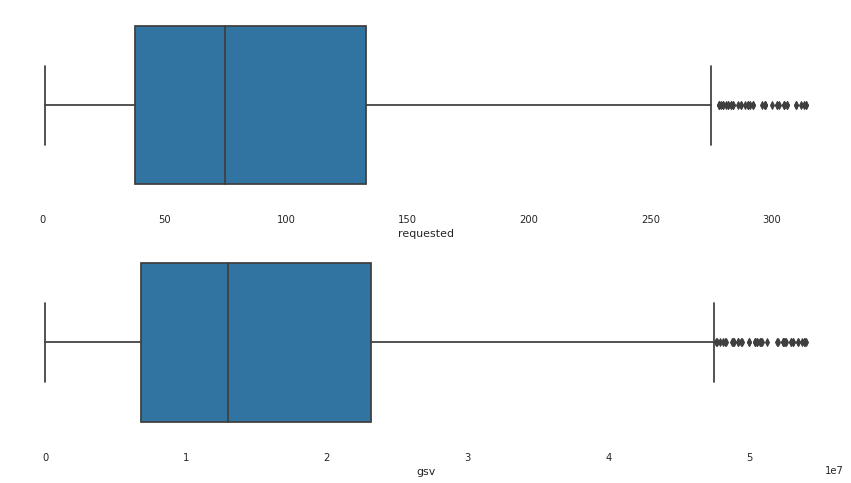

In [60]:
#Trực quan hóa kiểm tra xem còn outliers không
plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
sns.boxplot(df_final1['requested'])
plt.subplot(2,1,2)
sns.boxplot(df_final1['gsv'])
plt.show()

In [61]:
X = df_final1.drop('requested', axis=1)
y = df_final1['requested']

In [62]:
#Thực hiện encoding và scaling cho dữ liệu đầu vào - sử dụng pipeline 'preprocessor'
encode_scaling = preprocessor.fit(X)
processed_X = encode_scaling.transform(X)

#Chia bộ dữ liệu thành train, test theo tỉ lệ 70:30
X_train, X_test, y_train, y_test = train_test_split(processed_X,y,
                                                       test_size=0.30, random_state=0)

In [63]:
#Tìm k tối ưu của KNN
k = optimal_k(X_train, X_test, y_train, y_test)

The R^2 score is:  86.32488151758311  for K-Value: 2
The R^2 score is:  88.93079269444414  for K-Value: 3
The R^2 score is:  89.79291278551966  for K-Value: 4
The R^2 score is:  90.51348281027593  for K-Value: 5
The R^2 score is:  90.80778288624026  for K-Value: 6
The R^2 score is:  90.81472812793466  for K-Value: 7
The R^2 score is:  90.80382545540701  for K-Value: 8
The R^2 score is:  90.70503145792578  for K-Value: 9
The R^2 score is:  90.61229638623239  for K-Value: 10

The optimal number of neighbors is: 7 with R^2 score is: 90.81472812793466


In [64]:
#Tính toán và so sánh các thuật toán
cv_df = compute_models(X_train, X_test, y_train, y_test, k)

LinearRegression [0.9222210694189528, 0.9222210694189528, 0.9222210694189528, 0.9222210694189528, 0.9222210694189528]
SVR [0.7127063105834058, 0.7127063105834058, 0.7127063105834058, 0.7127063105834058, 0.7127063105834058]
RandomForestRegressor [0.9161070662396193, 0.9151937422701358, 0.9154930298821583, 0.9143408800571408, 0.9167819464700254]
[08:20:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:20:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:20:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:20:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:20:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor [0.929

In [ ]:
cv_df

model_name  score_train_mean  score_test_mean  abs|score|  \
0       LinearRegression              0.94             0.92        0.01   
1                    SVR              0.73             0.71        0.02   
2  RandomForestRegressor              0.99             0.92        0.07   
3           XGBRegressor              0.96             0.93        0.04   
4  DecisionTreeRegressor              1.00             0.86        0.14   
5    KNeighborsRegressor              0.94             0.91        0.03   

   time_mean  
0      12.78  
1     192.58  
2     624.16  
3      93.80  
4      33.84  
5       0.60

Vẫn chọn RandomForestRegressor

In [65]:
#Tìm số cây tối ưu cho RandomForest
list_trees =[30, 50, 70, 100, 150, 200, 250, 300, 350, 400, 450, 500]
list_r_score =[]

for tree in list_trees: 
  rd_forest = RandomForestRegressor(n_estimators=tree)
  rd_forest.fit(X_train,y_train)
  score = rd_forest.score(X_test,y_test)*100
  list_r_score.append(score)
  print('The R^2 score is: ', score, ' for tree number:', tree)

vi_tri = list_r_score.index(max(list_r_score))
optimal_tree = list_trees[vi_tri]

print('\nThe optimal number of trees is:', optimal_tree, 'with R^2 score is:', list_r_score[vi_tri])

The R^2 score is:  91.55614266969452  for tree number: 30
The R^2 score is:  91.52938027135245  for tree number: 50
The R^2 score is:  91.21897993656093  for tree number: 70
The R^2 score is:  91.34963500978736  for tree number: 100
The R^2 score is:  91.69442681940038  for tree number: 150
The R^2 score is:  91.65022398532531  for tree number: 200
The R^2 score is:  91.45578088851904  for tree number: 250
The R^2 score is:  91.48360466836122  for tree number: 300
The R^2 score is:  91.60818023865404  for tree number: 350
The R^2 score is:  91.59033875240648  for tree number: 400
The R^2 score is:  91.50085586103854  for tree number: 450
The R^2 score is:  91.47806753163054  for tree number: 500

The optimal number of trees is: 150 with R^2 score is: 91.69442681940038


In [66]:
rd_forest_model = RandomForestRegressor(n_estimators=optimal_tree)
rd_forest_model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=150)

In [67]:
print('Train score:', rd_forest_model.score(X_train,y_train)*100)
print('Test score:', rd_forest_model.score(X_test, y_test)*100)

Train score: 98.93063524014158
Test score: 91.49153900871877


**Kiểm tra các chỉ số sai số dự báo**

In [70]:
# Use the forest's predict method on the test data
y_pred = rd_forest_model.predict(X_test)
# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
mae = round(np.mean(errors),2) 
print('Mean Absolute Error:', mae,'%')

Mean Absolute Error: 6.8 %


In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors /y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape) 
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 81.08 %.


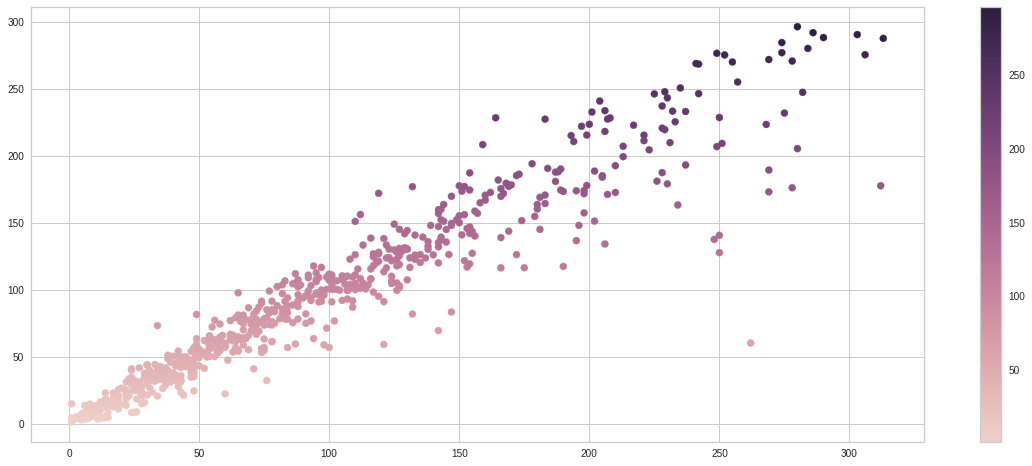

In [ ]:
# residual
>>> cmap = sns.cubehelix_palette(as_cmap=True)
>>> f, ax = plt.subplots(figsize=(20,8))
>>> points = ax.scatter(
y_test,y_pred, c=y_pred, s=50, cmap=cmap
 )
>>> f.colorbar(points)
>>> plt.show()

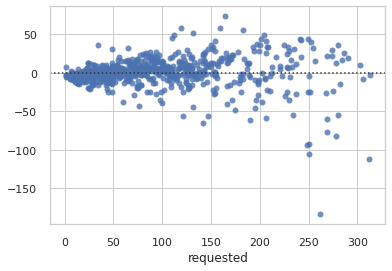

In [ ]:
sns.set_theme(style="whitegrid")
sns.residplot(x=y_test, y=y_pred,color="b")
plt.show()

In [71]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 6.802038095238094
Mean Squared Error: 427.5836805079365
Root Mean Squared Error: 20.678096636488004
